### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

!pip freeze > requirements.txt

### Загрузка датасетов

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Чтение файла из ноутбука

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

#### Описание датасета train

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

#### Описание датасета test

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

#### Описание полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту (target)

#### Описание датасета sample_submission

In [6]:
sample_submission.shape

(24354, 2)

In [7]:
df_test.shape

(36349, 18)

Количество строк в test не соответствует количеству строк в sample_submission.

### Разметка и объединение датасетов

In [8]:
#Флаги для разметки исходных датасетов train и test
df_train['is_test'] = 0
df_test['is_test'] = 1

#Конкатенация
df = pd.concat([df_train, df_test]).reset_index(drop=True)

#Просмотр датасета
df.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,is_test
5692,28883,04FEB2014,SCH,M,37,Y,Y,0,0,-1.666530,0,40,1,2,25000,4,3,N,0.0,0
3324,61228,10MAR2014,SCH,F,55,N,N,0,0,-1.446942,5,50,1,1,37000,2,3,N,0.0,0
29798,78998,27MAR2014,SCH,F,50,Y,Y,0,0,-1.789205,1,60,1,3,40000,1,4,N,0.0,0
16170,30992,06FEB2014,SCH,F,55,N,N,0,0,-2.258116,0,50,1,2,40000,1,3,N,0.0,0
76525,17069,24JAN2014,SCH,M,63,N,N,0,0,-1.935707,0,50,1,2,10000,1,1,N,NaN,1
53570,71520,19MAR2014,GRD,M,29,N,N,0,0,-1.715501,0,40,2,3,90000,1,4,N,0.0,0
103415,105875,24APR2014,SCH,M,43,N,N,0,0,-1.528442,2,80,2,3,35000,1,4,Y,NaN,1
18858,91407,07APR2014,GRD,F,30,N,N,0,0,-2.276264,0,60,2,3,50000,1,3,N,0.0,0
17324,36815,12FEB2014,PGR,M,34,Y,Y,0,0,-2.506849,1,80,2,3,300000,1,3,Y,0.0,0
14964,58155,06MAR2014,GRD,F,42,Y,Y,2,0,-1.545309,8,60,1,2,37000,1,3,N,0.0,0


In [9]:
df.shape

(110148, 20)

### Просмотр и заполнение пропусков

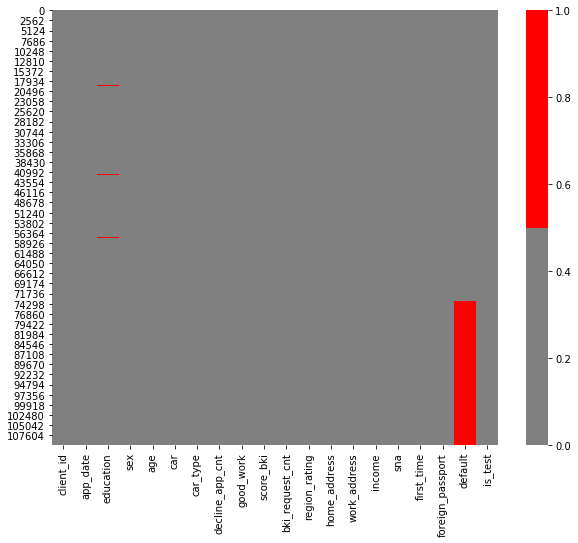

In [10]:
cols = df.columns 
plt.figure(figsize = (10,8))
#серый - непропущенные данные
#красный - пропуски
colours = ['grey', 'red'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Есть минимальные пропуски в поле education, их можно заполнить наиболее часто встречающимся значением.

In [11]:
df.education[df.education.isna()] = df.education.mode()[0]

C:\Users\Nataly\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
#Проверка заполнения
df.isna().sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
is_test                 0
dtype: int64

### Обработка даты

In [13]:
df.app_date = pd.to_datetime(df.app_date)
df.app_date.dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

In [14]:
df.app_date.dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

In [15]:
df[df.is_test==1].app_date.dt.month.value_counts()

3    10419
2     9069
4     8583
1     8278
Name: app_date, dtype: int64

In [16]:
df[df.is_test==0].app_date.dt.month.value_counts()

3    21178
2    18028
4    17683
1    16910
Name: app_date, dtype: int64

Все данные относятся к 2014 году, запросы были сделаны в январе - апреле, распределение данных в тестовой и тренировочной выборках примерно одинаковое. Максимальное количество приходится на март.

### Создание новых признаков

In [17]:
#Определим день подачи заявки
df['app_weekday'] = df.app_date.dt.weekday
df.app_weekday.value_counts()

1    18180
0    17858
2    17581
3    17421
4    16749
5    12202
6    10157
Name: app_weekday, dtype: int64

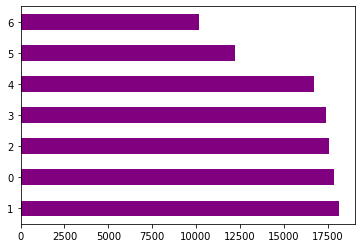

In [18]:
df['app_weekday'].value_counts().plot.barh(color = 'purple')

В выходные дни делается наименьшее количество зявок, они примерно одинаково распределены по будним дням.

In [19]:
#Распределим заявки по числам
#Преобразование даты в число
df.app_date = df.app_date.dt.strftime('%m%d').astype('int64')

#Количество заявок в день
apps_per_date = df.app_date.value_counts()
df['apps_per_day'] = df.app_date.map(apps_per_date)

### Группировка и обработка признаков

In [20]:
#Бинарные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#Категориальные
cat_cols = ['education', 'home_address', 'work_address',
        'sna', 'first_time',
            'app_weekday'
           ]

#Числовые
num_cols = ['app_date', 'age', 'decline_app_cnt', 'score_bki',
        'bki_request_cnt', 'region_rating', 'income',
            'apps_per_day'
           ]

#### Числовые признаки

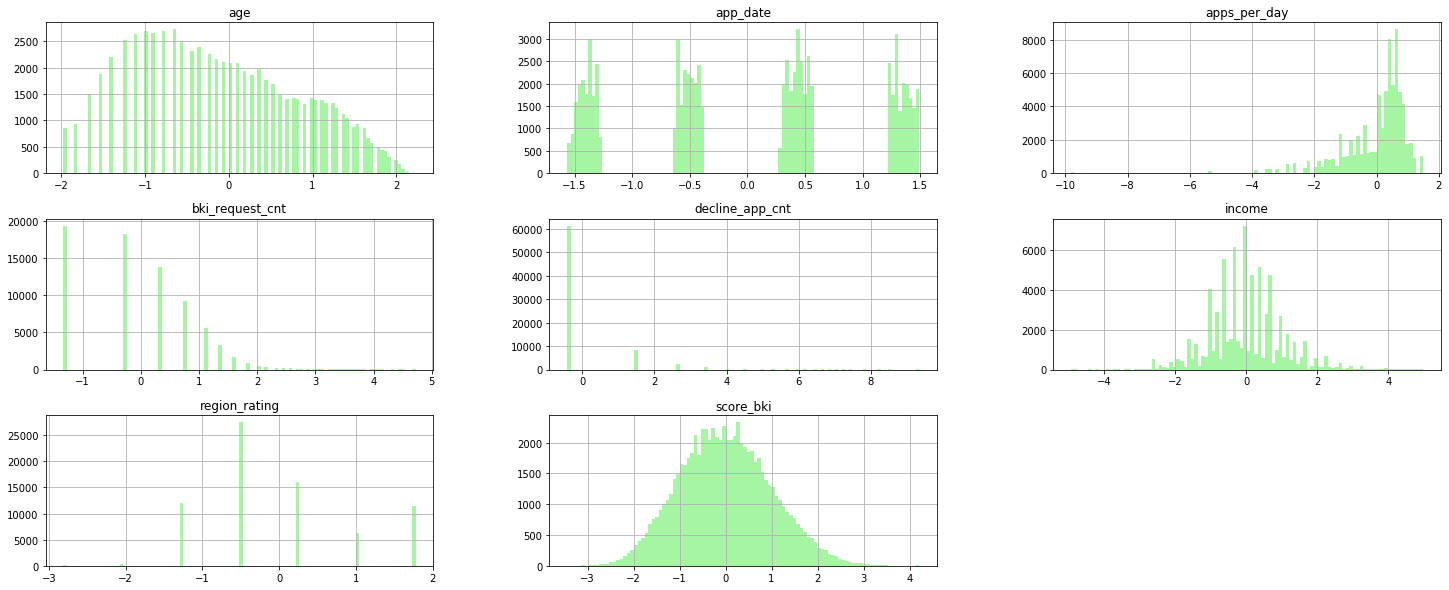

In [49]:
df[df.is_test == 0][num_cols].hist(figsize=(25,10),bins=100, color='#A5F5A3');

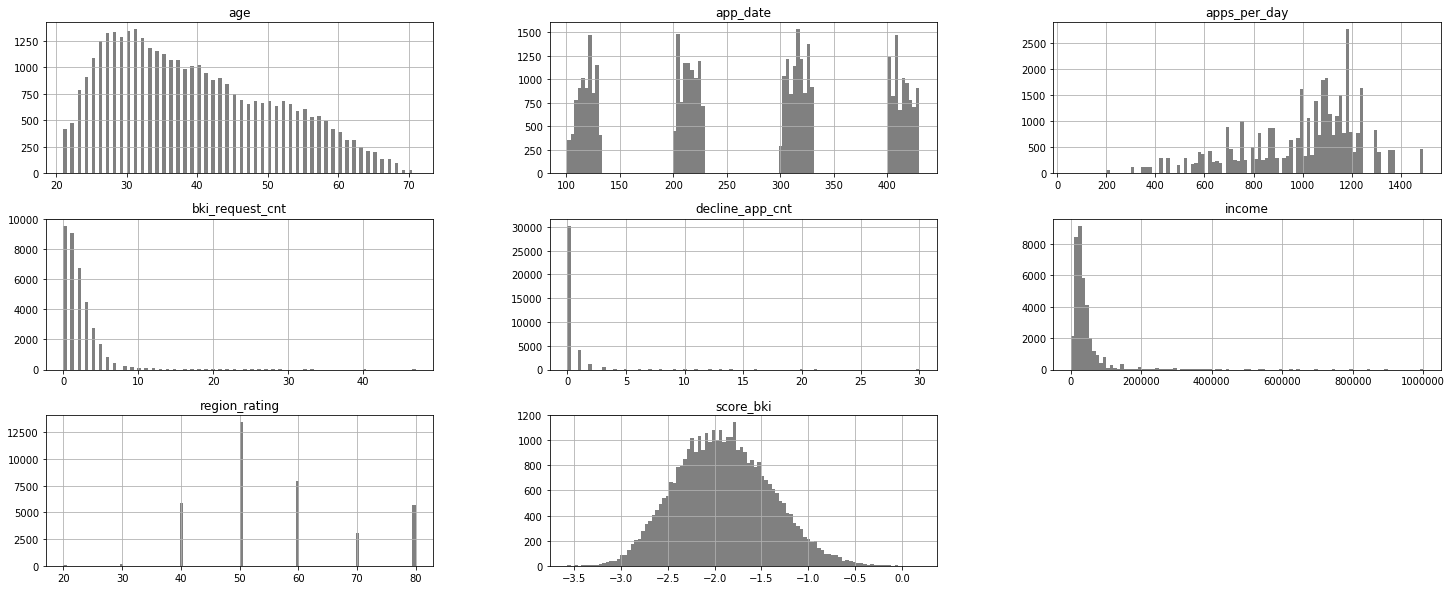

In [22]:
df[df.is_test == 1][num_cols].hist(figsize=(25,10),bins=100, color='grey');

В тестовой и тренировочной выборках распределение признаков схожее. Часть признаков распределено неравномерно, логарифмируем их.

In [23]:
#Список признаков для логарифмирования
num_cols_log = ['age', 'apps_per_day', 'bki_request_cnt', 'decline_app_cnt', 'income']
for i in [num_cols_log]:
    df[i] = np.log(df[i]+1)

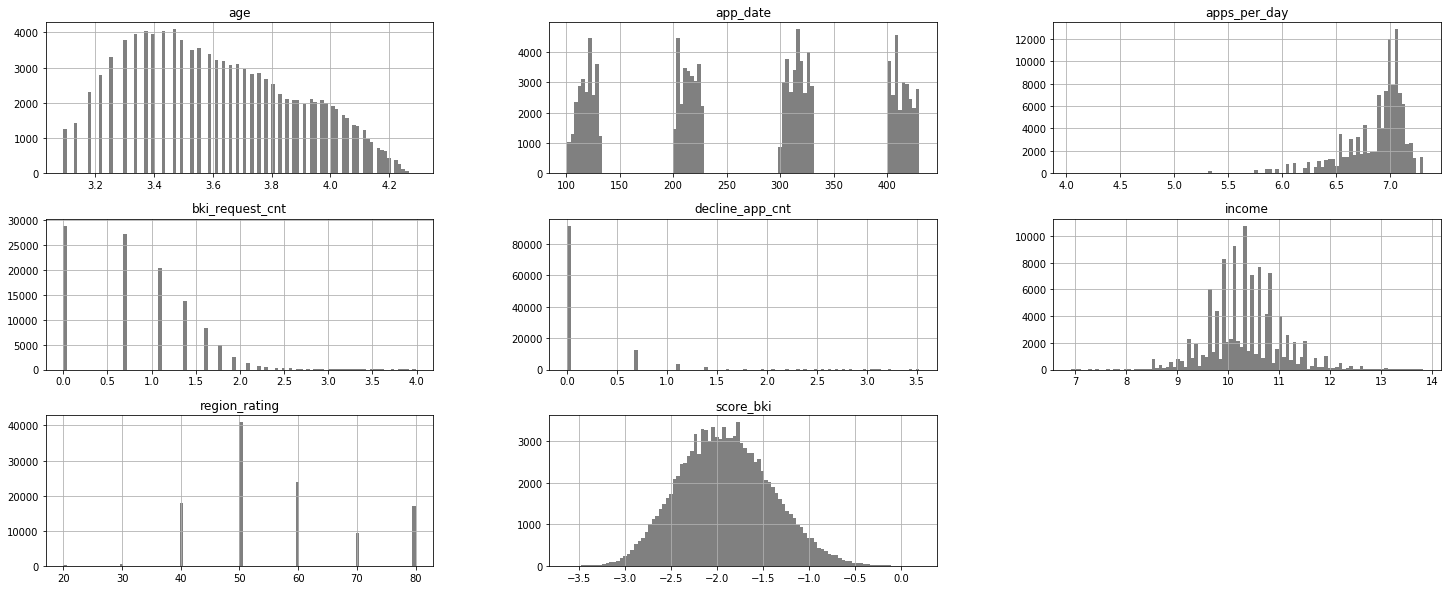

In [24]:
#Проверка распределения
df[num_cols].hist(figsize=(25,10),bins=100, color='grey');


Сейчас распределение некотрых признаков выглядит более нормальным, особенно это удалось с income.

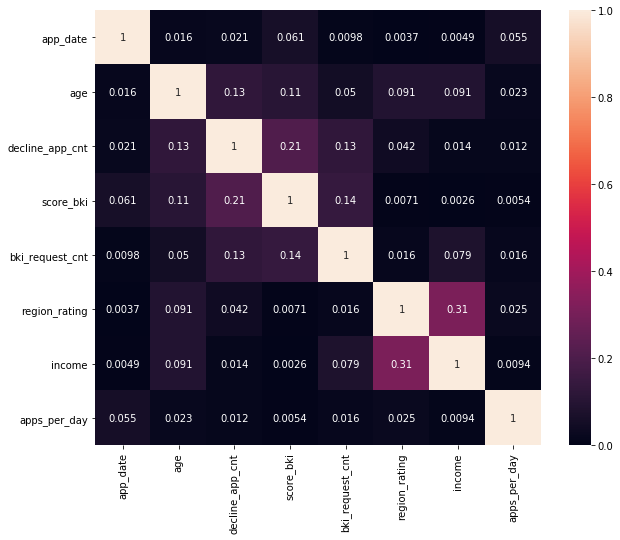

In [25]:
#Корреляция числовых признаков
plt.figure(figsize = (10,8))
sns.heatmap(df[num_cols].corr().abs(), annot = True, vmin=0, vmax=1)

Корреляции незначительны, больше всего сопряжены доход и рейтинг региона.

In [26]:
#Стандартизация
sscaler = StandardScaler()
df[num_cols] = pd.DataFrame(sscaler.fit_transform(df[num_cols]),columns=num_cols)
df[num_cols].describe()

,app_date,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income,apps_per_day
count,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05,1.101480e+05
mean,-1.173637e-16,1.004110e-15,-3.789093e-15,-4.903485e-16,3.587481e-16,-2.509444e-15,7.210120e-16,1.100831e-15
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.564737e+00,-1.976836e+00,-4.188152e-01,-3.444269e+00,-1.334144e+00,-2.812764e+00,-4.933787e+00,-9.824902e+00
25%,-6.173676e-01,-7.737452e-01,-4.188152e-01,-7.126592e-01,-1.334144e+00,-5.167044e-01,-6.348458e-01,-4.581614e-01
50%,3.207140e-01,-5.949589e-02,-4.188152e-01,-3.261521e-02,-2.817904e-01,-5.167044e-01,-5.283405e-02,3.506224e-01
75%,5.714883e-01,8.323877e-01,-4.188152e-01,6.741092e-01,7.705631e-01,2.486488e-01,6.218273e-01,6.658192e-01
max,1.490994e+00,2.230861e+00,9.340604e+00,4.213712e+00,4.722032e+00,1.779355e+00,4.980702e+00,1.497070e+00


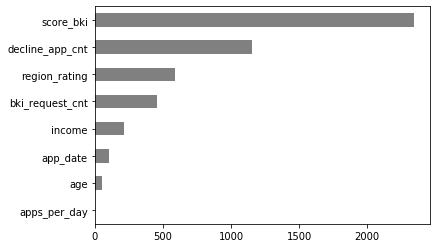

In [27]:
#Оценка значимости числовых признаков
imp_num = pd.Series(f_classif(df[df.is_test==0][num_cols], df[df.is_test==0]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color = 'grey')

Скоринговый балл по данным из БКИ является наиболее значимым.

#### Бинарные признаки

In [28]:
#Преобразование в числа
label_encoder = LabelEncoder()

for i in bin_cols:
    df[i] = label_encoder.fit_transform(df[i])  

In [29]:
df[bin_cols].describe()

,sex,car,car_type,good_work,foreign_passport
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,0.438610,0.325544,0.190725,0.165514,0.149136
std,0.496219,0.468580,0.392875,0.371645,0.356224
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
#Стандартизация
df[bin_cols] = pd.DataFrame(sscaler.fit_transform(df[bin_cols]),columns=bin_cols)

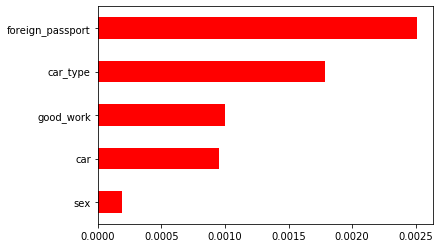

In [31]:
#Оценка значимости
imp_cat = pd.Series(mutual_info_classif(df[df.is_test == 0][bin_cols], df[df.is_test == 0]['default'],
                                        discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', color = 'red')

Наличие загранпаспорта является наиболее значимым признаком.

In [32]:
#Преобразование категориальных признаков в dummies
df_dummies = pd.get_dummies(df[cat_cols].astype('object'))
dummy_cols = df_dummies.columns
df = pd.concat([df, df_dummies], axis=1)
df.drop(columns=cat_cols, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 42 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  float64
 2   sex               110148 non-null  float64
 3   age               110148 non-null  float64
 4   car               110148 non-null  float64
 5   car_type          110148 non-null  float64
 6   decline_app_cnt   110148 non-null  float64
 7   good_work         110148 non-null  float64
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  float64
 10  region_rating     110148 non-null  float64
 11  income            110148 non-null  float64
 12  foreign_passport  110148 non-null  float64
 13  default           73799 non-null   float64
 14  is_test           110148 non-null  int64  
 15  apps_per_day      110148 non-null  float64
 16  education_ACD     11

In [33]:
cat_cols=dummy_cols

### Модель

In [34]:
x = df[df.is_test == 0].drop(columns=['client_id','default']) #удаление ID
y = df[df.is_test == 0]['default'] #целевая переменная
x_pred = df[df.is_test == 1].drop(columns=['client_id','default'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=13)

#Модель - логистическая регрессия
model = LogisticRegression(random_state=13, max_iter=1000, solver='lbfgs')
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
probs = model.predict_proba(x_test)
probs = probs[:, 1]

#### Оценка качества модели

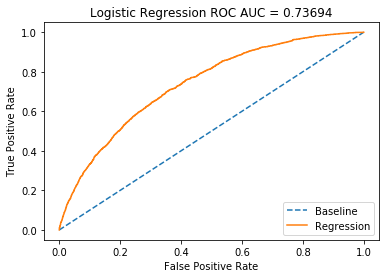

In [36]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

#### Промежуточный результат: 0.737

### Регуляризация

In [37]:
#Тип регуляризации
penalty = ['l2']

#Ограничения параметра регуляризации
C = np.logspace(0, 2, 20)
C

array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ])

In [38]:
#Гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

#Сетка поиска с использованием 5-кратной перекрестной проверки
model = LogisticRegression(random_state=13, max_iter=1000, solver='lbfgs')
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(x_train, y_train)

#Просмотр лучших гиперпараметров
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 29.76351441631318


In [39]:
p = best_model.best_estimator_.get_params()['penalty']
c = best_model.best_estimator_.get_params()['C']

model = LogisticRegression(penalty=p,C=c, random_state=13, max_iter=1000, solver='lbfgs')

model.fit(x_train, y_train)

LogisticRegression(C=29.76351441631318, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
probs = model.predict_proba(x_test)
probs = probs[:, 1]

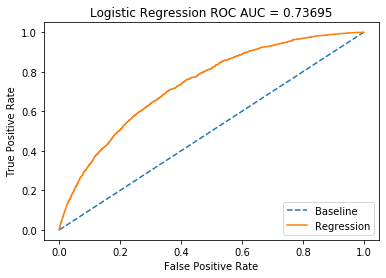

In [41]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Регуляризация не привела к видимому улучшению качества модели.

### Результат

In [42]:
y_pred = model.predict(x_pred)
y_pred_proba = model.predict_proba(x_pred)

In [43]:
x_pred

,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,first_time_2,first_time_3,first_time_4,app_weekday_0,app_weekday_1,app_weekday_2,app_weekday_3,app_weekday_4,app_weekday_5,app_weekday_6
73799,0.487897,1.131340,-0.888776,1.439369,2.059890,-0.418815,-0.445356,-0.735587,0.770563,-0.516704,...,0,0,1,0,0,0,0,0,1,0
73800,-1.351115,-0.883907,0.120447,-0.694749,-0.485463,4.539989,-0.445356,0.800039,0.333797,-0.516704,...,0,1,0,0,0,0,0,1,0,0
73801,0.497185,1.131340,0.972731,1.439369,2.059890,-0.418815,-0.445356,0.426908,-0.281790,-0.516704,...,0,1,0,0,0,0,0,0,0,1
73802,-0.617368,1.131340,1.362924,-0.694749,-0.485463,-0.418815,-0.445356,-0.940432,-0.281790,-1.282058,...,0,1,0,1,0,0,0,0,0,0
73803,-0.608080,-0.883907,0.031629,-0.694749,-0.485463,-0.418815,-0.445356,-1.167347,-1.334144,1.779355,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0.571488,-0.883907,-0.059496,-0.694749,-0.485463,1.499512,-0.445356,0.319505,0.770563,-0.516704,...,0,0,0,1,0,0,0,0,0,0
110144,1.444554,-0.883907,1.823666,1.439369,2.059890,-0.418815,-0.445356,-0.779436,0.770563,0.248649,...,0,0,1,0,0,0,0,1,0,0
110145,0.562200,1.131340,-0.662367,-0.694749,-0.485463,2.621662,-0.445356,1.929901,-0.281790,-0.516704,...,1,0,0,0,0,0,0,0,0,1
110146,-1.509010,-0.883907,-1.130811,-0.694749,-0.485463,1.499512,-0.445356,1.325890,0.333797,1.779355,...,0,0,0,0,1,0,0,0,0,0


In [44]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
y_pred_proba[:,1]

array([0.04031021, 0.3430527 , 0.06373181, ..., 0.3465715 , 0.18827028,
       0.25849982])

In [46]:
len(y_pred)

36349

In [47]:
submission_proba = df_test.client_id.to_frame()
submission_proba['default'] = y_pred_proba[:,1]
submission_proba

,client_id,default
0,74835,0.040310
1,17527,0.343053
2,75683,0.063732
3,26883,0.089831
4,28862,0.026071
...,...,...
36344,83775,0.337663
36345,106254,0.015793
36346,81852,0.346572
36347,1971,0.188270


In [48]:
submission_proba.to_csv('submission.csv', index = False)